<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/Copy_of_1_Bidirectional_LSTM_Multivariate_Horizon_Style_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [92]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
 #               infer_datetime_format=True)
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/Network-Flows.csv'
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



#df = pd.read_csv(url,index_col='Processing_time',
#               # infer_datetime_format=True)
#                parse_dates=True)

In [93]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [94]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [95]:
#df.drop_duplicates(subset=['Processing_time'], keep=False,inplace=True)

In [96]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [97]:
#df = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

df = df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [98]:
#validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100)
validate = df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(250)
df.drop(df.tail(250).index,inplace=True)

In [99]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [100]:
#validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100)
validate = df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(250)

df.drop(df.tail(250).index,inplace=True)

In [101]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [102]:
"""
#hist_window = 48
#horizon = 10
hist_window =35
#horizon = 30
horizon = 10
"""
#hist_window =200
#hist_window =300
#hist_window =50
hist_window =200
horizon = 250


TRAIN_SPLIT = 5574
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [103]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[1.         0.00318907 0.49756098 ... 0.83064738 0.53022238 0.        ]
 [1.         0.00501139 0.0195122  ... 0.51308245 0.95353474 0.        ]
 [1.         0.00592255 0.2097561  ... 0.65795782 0.94257725 0.        ]
 ...
 [1.         0.00364465 0.10243902 ... 0.52669867 0.96932836 0.        ]
 [1.         0.00501139 0.0097561  ... 0.53031049 0.96204801 0.        ]
 [1.         0.00455581 0.1804878  ... 0.54001445 0.95218581 0.        ]]

 Target horizon
[[0.97162017]
 [0.96124957]
 [0.94890789]
 [0.96516897]
 [0.94999181]
 [0.95613478]
 [0.93448254]
 [0.97018708]
 [0.95124634]
 [0.96261101]
 [0.54209205]
 [0.94252493]
 [0.94991219]
 [0.94535245]
 [0.97325686]
 [0.95814112]
 [0.95357227]
 [0.94797069]
 [0.95336868]
 [0.95260892]
 [0.93442794]
 [0.55474309]
 [0.93985778]
 [0.94055044]
 [0.95139761]
 [0.9517138 ]
 [0.95499741]
 [0.96532593]
 [0.9443527 ]
 [0.95185142]
 [0.94896248]
 [0.96180688]
 [0.56276387]
 [0.96200934]
 [0.97071596]
 [0.96332642]
 [0.9

In [104]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 37
#BATCH_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [105]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


In [106]:
model_path = r'Bidirectional_LSTM_Multivariate.h5'

In [107]:
#EVALUATION_INTERVAL = 100
#EPOCHS = 150
#EVALUATION_INTERVAL = 70
EVALUATION_INTERVAL = 100
#EPOCHS = 150
EPOCHS = 150
#history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 15s 109ms/step - loss: 0.2206 - val_loss: 0.0331
Epoch 2/150
100/100 [==============================] - 10s 99ms/step - loss: 0.0588 - val_loss: 0.0294
Epoch 3/150
100/100 [==============================] - 10s 101ms/step - loss: 0.0529 - val_loss: 0.0198
Epoch 4/150
100/100 [==============================] - 10s 101ms/step - loss: 0.0482 - val_loss: 0.0249
Epoch 5/150
100/100 [==============================] - 10s 100ms/step - loss: 0.0436 - val_loss: 0.0416
Epoch 6/150
100/100 [==============================] - 10s 101ms/step - loss: 0.0413 - val_loss: 0.0302
Epoch 7/150
100/100 [==============================] - 10s 99ms/step - loss: 0.0363 - val_loss: 0.0171
Epoch 8/150
100/100 [==============================] - 10s 98ms/step - loss: 0.0294 - val_loss: 0.0115
Epoch 9/150
100/100 [==============================] - 10s 99ms/step - loss: 0.0269 - val_loss: 0.0115
Epoch 10/150
100/100 [==============================] - 10s 100ms/st

In [108]:
Trained_model = tf.keras.models.load_model(model_path)

In [109]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 200, 300)          190800    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               5250      
Total params: 338,470
Trainable params: 338,470
Non-trainable params: 0
_________________________________________________________________


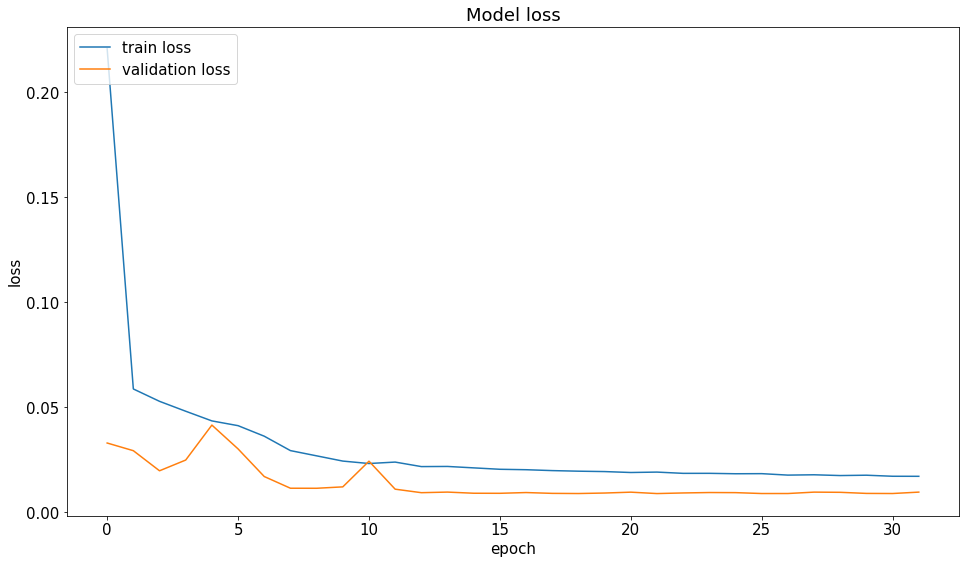

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [111]:
data_val = x_scaler.fit_transform(df[['avg_tcp_window_size','std_dev_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(200))

In [112]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [113]:
Predicted_results = Trained_model.predict(val_rescaled)

In [114]:
Predicted_results

array([[0.6840597 , 0.69357497, 0.6985671 , 0.69454646, 0.6922153 ,
        0.7010738 , 0.68817186, 0.69268286, 0.6907414 , 0.69464   ,
        0.6983334 , 0.69886565, 0.6837518 , 0.6941118 , 0.69666827,
        0.69798625, 0.6943957 , 0.69840276, 0.6975825 , 0.6901819 ,
        0.69141614, 0.6904545 , 0.68985474, 0.6907269 , 0.688393  ,
        0.69552994, 0.6975088 , 0.6993253 , 0.6970894 , 0.6891571 ,
        0.6933948 , 0.690997  , 0.69764435, 0.69594896, 0.69519675,
        0.6925198 , 0.6992842 , 0.69838446, 0.69390756, 0.70157635,
        0.69929963, 0.6936676 , 0.69256   , 0.6954622 , 0.6893351 ,
        0.6942308 , 0.6960186 , 0.7001296 , 0.69418   , 0.6986958 ,
        0.6972914 , 0.692429  , 0.6994391 , 0.6999965 , 0.6865744 ,
        0.69650656, 0.68928486, 0.6961076 , 0.69297457, 0.6947576 ,
        0.6985961 , 0.6972154 , 0.6996327 , 0.6992382 , 0.69947296,
        0.69183767, 0.6873738 , 0.6833583 , 0.6921076 , 0.69681543,
        0.696793  , 0.69780976, 0.69145817, 0.68

In [115]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [116]:
Predicted_results_Inv_trans

array([[645508.25, 653874.25, 658263.4 , 654728.4 , 652678.8 , 660467.3 ,
        649123.75, 653089.9 , 651382.94, 654810.6 , 658057.9 , 658525.9 ,
        645237.56, 654346.25, 656593.9 , 657752.7 , 654595.8 , 658118.9 ,
        657397.7 , 650891.  , 651976.1 , 651130.6 , 650603.3 , 651370.1 ,
        649318.1 , 655593.06, 657332.94, 658930.  , 656964.1 , 649990.  ,
        653715.8 , 651607.6 , 657452.06, 655961.5 , 655300.1 , 652946.5 ,
        658893.9 , 658102.8 , 654166.6 , 660909.2 , 658907.44, 653955.7 ,
        652981.9 , 655533.56, 650146.5 , 654450.8 , 656022.7 , 659637.2 ,
        654406.2 , 658376.5 , 657141.75, 652866.7 , 659030.06, 659520.1 ,
        647719.2 , 656451.75, 650102.3 , 656101.  , 653346.3 , 654914.  ,
        658288.9 , 657074.94, 659200.3 , 658853.44, 659059.8 , 652346.75,
        648422.06, 644891.56, 652584.1 , 656723.3 , 656703.56, 657597.5 ,
        652013.1 , 645694.8 , 656846.2 , 656891.75, 656571.7 , 658416.7 ,
        653639.8 , 656296.25, 656955.8

In [117]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [118]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 6703108648.570562
MAE is : 58603.708
RMSE is : 81872.51461003603
MAPE is : 10.48509589705606
R2 is : -0.0473884573567096



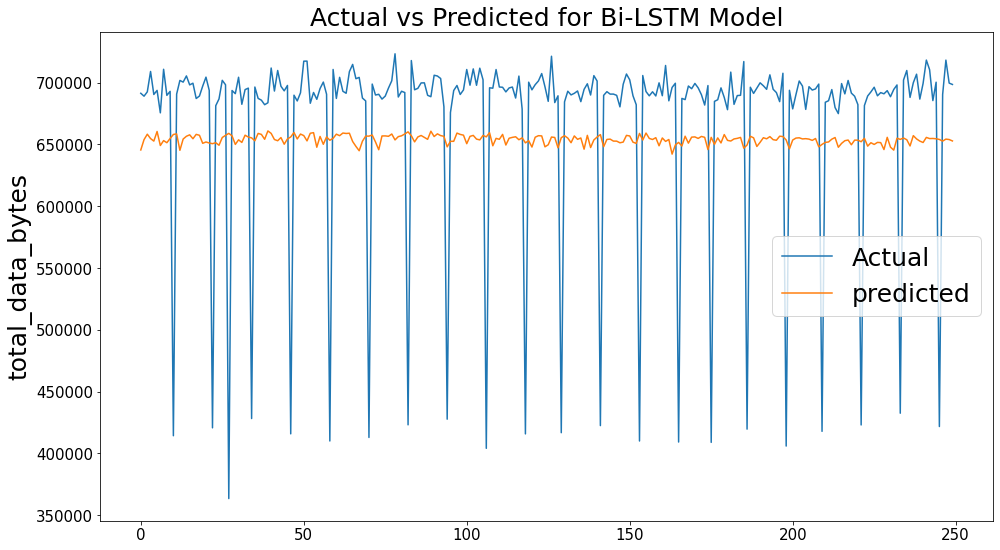

In [119]:
#plt.plot( list(validate['total_data_bytes']))
#plt.plot( list(Predicted_results_Inv_trans[0]))
#plt.title("Actual vs Predicted")
#plt.ylabel("total_data_bytes")
#plt.legend(('Actual','predicted'))

plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.rcParams.update({'font.size': 15})
plt.title("Actual vs Predicted for Bi-LSTM Model", fontsize=25)
plt.ylabel("total_data_bytes", fontsize=25)
plt.legend(('Actual','predicted'), fontsize=25)
#plt.legend(loc=5, prop={'size': 10})
###plt.rc('legend', fontsize='medium')
plt.show()

plt.show()